## Business Understanding

- The key stakeholders for this analysis project are potential home buyers who are relocating to work for Amazon moving to the King County area
    - Specifically within a 3 mile radius from Amazon for a short commute
- I are using a data set of recent house sales in King County from 2021-2022 to create a predictive model
- I used predictive modeling to predict prices based on certain home features
- I recommend that once a potential home buyer does buy their home, to bolster certain features of their homes to add value

## Importing the Data/Packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

In [2]:
df = pd.read_csv('./data/kc_house_data.csv')

## Data Understanding/Cleaning

In [3]:
# taking a look at the columns, nulls and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [4]:
# dropping null values, dropping id column, dropping duplicates and resetting dataframe index
df.dropna(inplace = True)
df.drop(columns = 'id', inplace = True)
df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace = True)

Standardize all categorical columns to make sure that they are all lowercase and have no unnecessary spaces. I also need to change the date column from object to datetime.

In [5]:
# standardizing categorical columns and changing date column to datetime
cat_columns = ['waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 
               'grade', 'heat_source', 'sewer_system', 'address']
def standard(dataframe, column_to_clean):
    cleaned_df = dataframe.copy()
    
    for column in column_to_clean:
        if column in cleaned_df:
            cleaned_df[column] = cleaned_df[column].str.lower().str.strip()
    return cleaned_df

df = standard(df, cat_columns)
df['date'] = pd.to_datetime(df['date'])

In [6]:
# viewing unique values in some of the categorical columns
def unique_and_counts(dataframe, columns):
    df = dataframe.copy()
    
    for column in columns:
        if column in df:
            print(column.upper(), 'column unique values and counts:')
            print(df[column].value_counts())
    return
clmns_to_see = ['view', 'condition', 'grade', 'heat_source', 'sewer_system']
unique_and_counts(df, clmns_to_see)

VIEW column unique values and counts:
none         26552
average       1910
good           877
excellent      549
fair           220
Name: view, dtype: int64
CONDITION column unique values and counts:
average      18512
good          8052
very good     3258
fair           225
poor            61
Name: condition, dtype: int64
GRADE column unique values and counts:
7 average        11693
8 good            9398
9 better          3803
6 low average     2852
10 very good      1369
11 excellent       406
5 fair             385
12 luxury          122
4 low               46
13 mansion          24
3 poor               9
2 substandard        1
Name: grade, dtype: int64
HEAT_SOURCE column unique values and counts:
gas                  20575
electricity           6458
oil                   2899
gas/solar               93
electricity/solar       59
other                   20
oil/solar                4
Name: heat_source, dtype: int64
SEWER_SYSTEM column unique values and counts:
public               

In [7]:
# taking a look at the numerical columns
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,3.010800e+04,30108.000000,30108.000000,30108.000000,3.010800e+04,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000
mean,1.108463e+06,3.415238,2.335642,2113.326857,1.665012e+04,1.543394,1810.402983,476.588548,330.491630,217.436064,1975.157931,90.801813,47.328884,-121.320528
std,8.947558e+05,0.979795,0.888285,973.461912,5.993586e+04,0.567688,877.745363,579.809205,285.724889,245.308714,32.051539,416.217375,1.432483,5.720625
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480
25%,6.490000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405383,-122.326083
50%,8.600000e+05,3.000000,2.500000,1920.000000,7.477000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551443,-122.225845
75%,1.300000e+06,4.000000,3.000000,2620.000000,1.056800e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669916,-122.116399
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340


Want to extract zipcode from the address column.

In [8]:
# creating a function to get zip codes from addresses and creating the zip_code column
def zip_code(address):
    x = address.split(' ')[-3]
    return x.split(',')[0]
df['zip_code'] = df['address'].apply(lambda x: zip_code(x))
df['zip_code'] = df['zip_code'].astype(int)

In [9]:
# looking at the number of unique zip codes
df['zip_code'].nunique()

399

Need to make sure that all the zip codes are in King County Washington. Went on to zillow and found all the appropriate zip codes.

In [10]:
# real king county zip codes and number of different zip codes
king_county_zips = [
    98052, 98105, 98092, 98115, 98023, 98103, 98003, 98042, 98034, 98133, 98118, 98125, 98031, 98058, 98122,
    98032, 98059, 98033, 98004, 98006, 98001, 98117, 98030, 98056, 98155, 98198, 98168, 98002, 98038, 98109, 
    98040, 98029, 98027, 98074, 98146, 98144, 98007, 98072, 98011, 98188, 98008, 98107, 98106, 98178, 98116,
    98075, 98108, 98112, 98028, 98119, 98055, 98053, 98126, 98199, 98177, 98022, 98102, 98166, 98005, 98121,
    98136, 98045, 98101, 98104, 98077, 98057, 98065, 98019, 98070, 98148, 98014, 98354, 98051, 98010, 98024,
    98047, 98151, 98251, 98134, 98039, 98158, 98195, 98288, 98174, 98132, 98171, 98184, 98054, 98224, 98164,
    98181, 98009, 98013, 98015, 98025, 98035, 98041, 98050, 98062, 98064, 98063, 98071, 98073, 98083, 98089,
    98093, 98111, 98113, 98114, 98124, 98127, 98131, 98129, 98139, 98138, 98141, 98145, 98154, 98160, 98161,
    98165, 98170, 98175, 98185, 98190, 98194, 98191
]
len(king_county_zips)

127

Appears that many of the zip codes in the dataframe are not in King County Washington. Lets get rid of those.

In [11]:
# data frame with real zip codes
real_df = df[df['zip_code'].isin(king_county_zips)]
real_df.reset_index(drop = True, inplace = True)
real_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip_code
0,2022-05-24,675000.0,4,1.0,1180,7140,1.0,no,no,no,...,1180,0,0,40,1969,0,"2102 southeast 21st court, renton, washington ...",47.461975,-122.19052,98055
1,2021-12-13,920000.0,5,2.5,2770,6703,1.0,no,no,yes,...,1570,1570,0,240,1950,0,"11231 greenwood avenue north, seattle, washing...",47.711525,-122.35591,98133
2,2021-09-29,311000.0,6,2.0,2880,6156,1.0,no,no,no,...,1580,1580,0,0,1956,0,"8504 south 113th street, seattle, washington 9...",47.502045,-122.22520,98178
3,2021-12-14,775000.0,3,3.0,2160,1400,2.0,no,no,no,...,1090,1070,200,270,2010,0,"4079 letitia avenue south, seattle, washington...",47.566110,-122.29020,98118
4,2021-08-24,592500.0,2,2.0,1120,758,2.0,no,no,yes,...,1120,550,550,30,2012,0,"2193 northwest talus drive, issaquah, washingt...",47.532470,-122.07188,98027


In [12]:
# how many houses sold in each zip code
real_df['zip_code'].value_counts()

98042    992
98038    857
98103    761
98115    760
98117    748
        ... 
98354     23
98288     16
98224      3
98251      3
98050      2
Name: zip_code, Length: 78, dtype: int64

In [13]:
# zipping the lat and long columns to one location column
real_df = real_df.copy()
real_df['location'] = list(zip(real_df['lat'], real_df['long']))
real_df['location'].head()

0    (47.461975, -122.19052)
1    (47.711525, -122.35591)
2     (47.502045, -122.2252)
3      (47.56611, -122.2902)
4     (47.53247, -122.07188)
Name: location, dtype: object

In [14]:
# Amazon headquarter coordinates
amzn_coord = (47.615722, -122.339494)

In [15]:
# function to take two lat/long on two locations and calculate distance in miles
def geo_distance(coord_a, coord_b):
    
    return geodesic(coord_a, coord_b).miles

In [16]:
# calculating the distance to amazon using location coordinates and amazon coordinates
real_df['distance_to_amazon'] = real_df['location'].apply(lambda x: geodesic(x, amzn_coord).miles)

Want to only have houses within a three mile radius of Amazon headquarter so I need to filter the dataframe

In [17]:
# filtering the dataframe to close proximity to amazon 3 miles and less than 5 million dollars
amazon_df = real_df[(real_df['distance_to_amazon'] <= 3.00) & (real_df['price'] < 5000000)]
amazon_df.reset_index(drop = True, inplace = True)

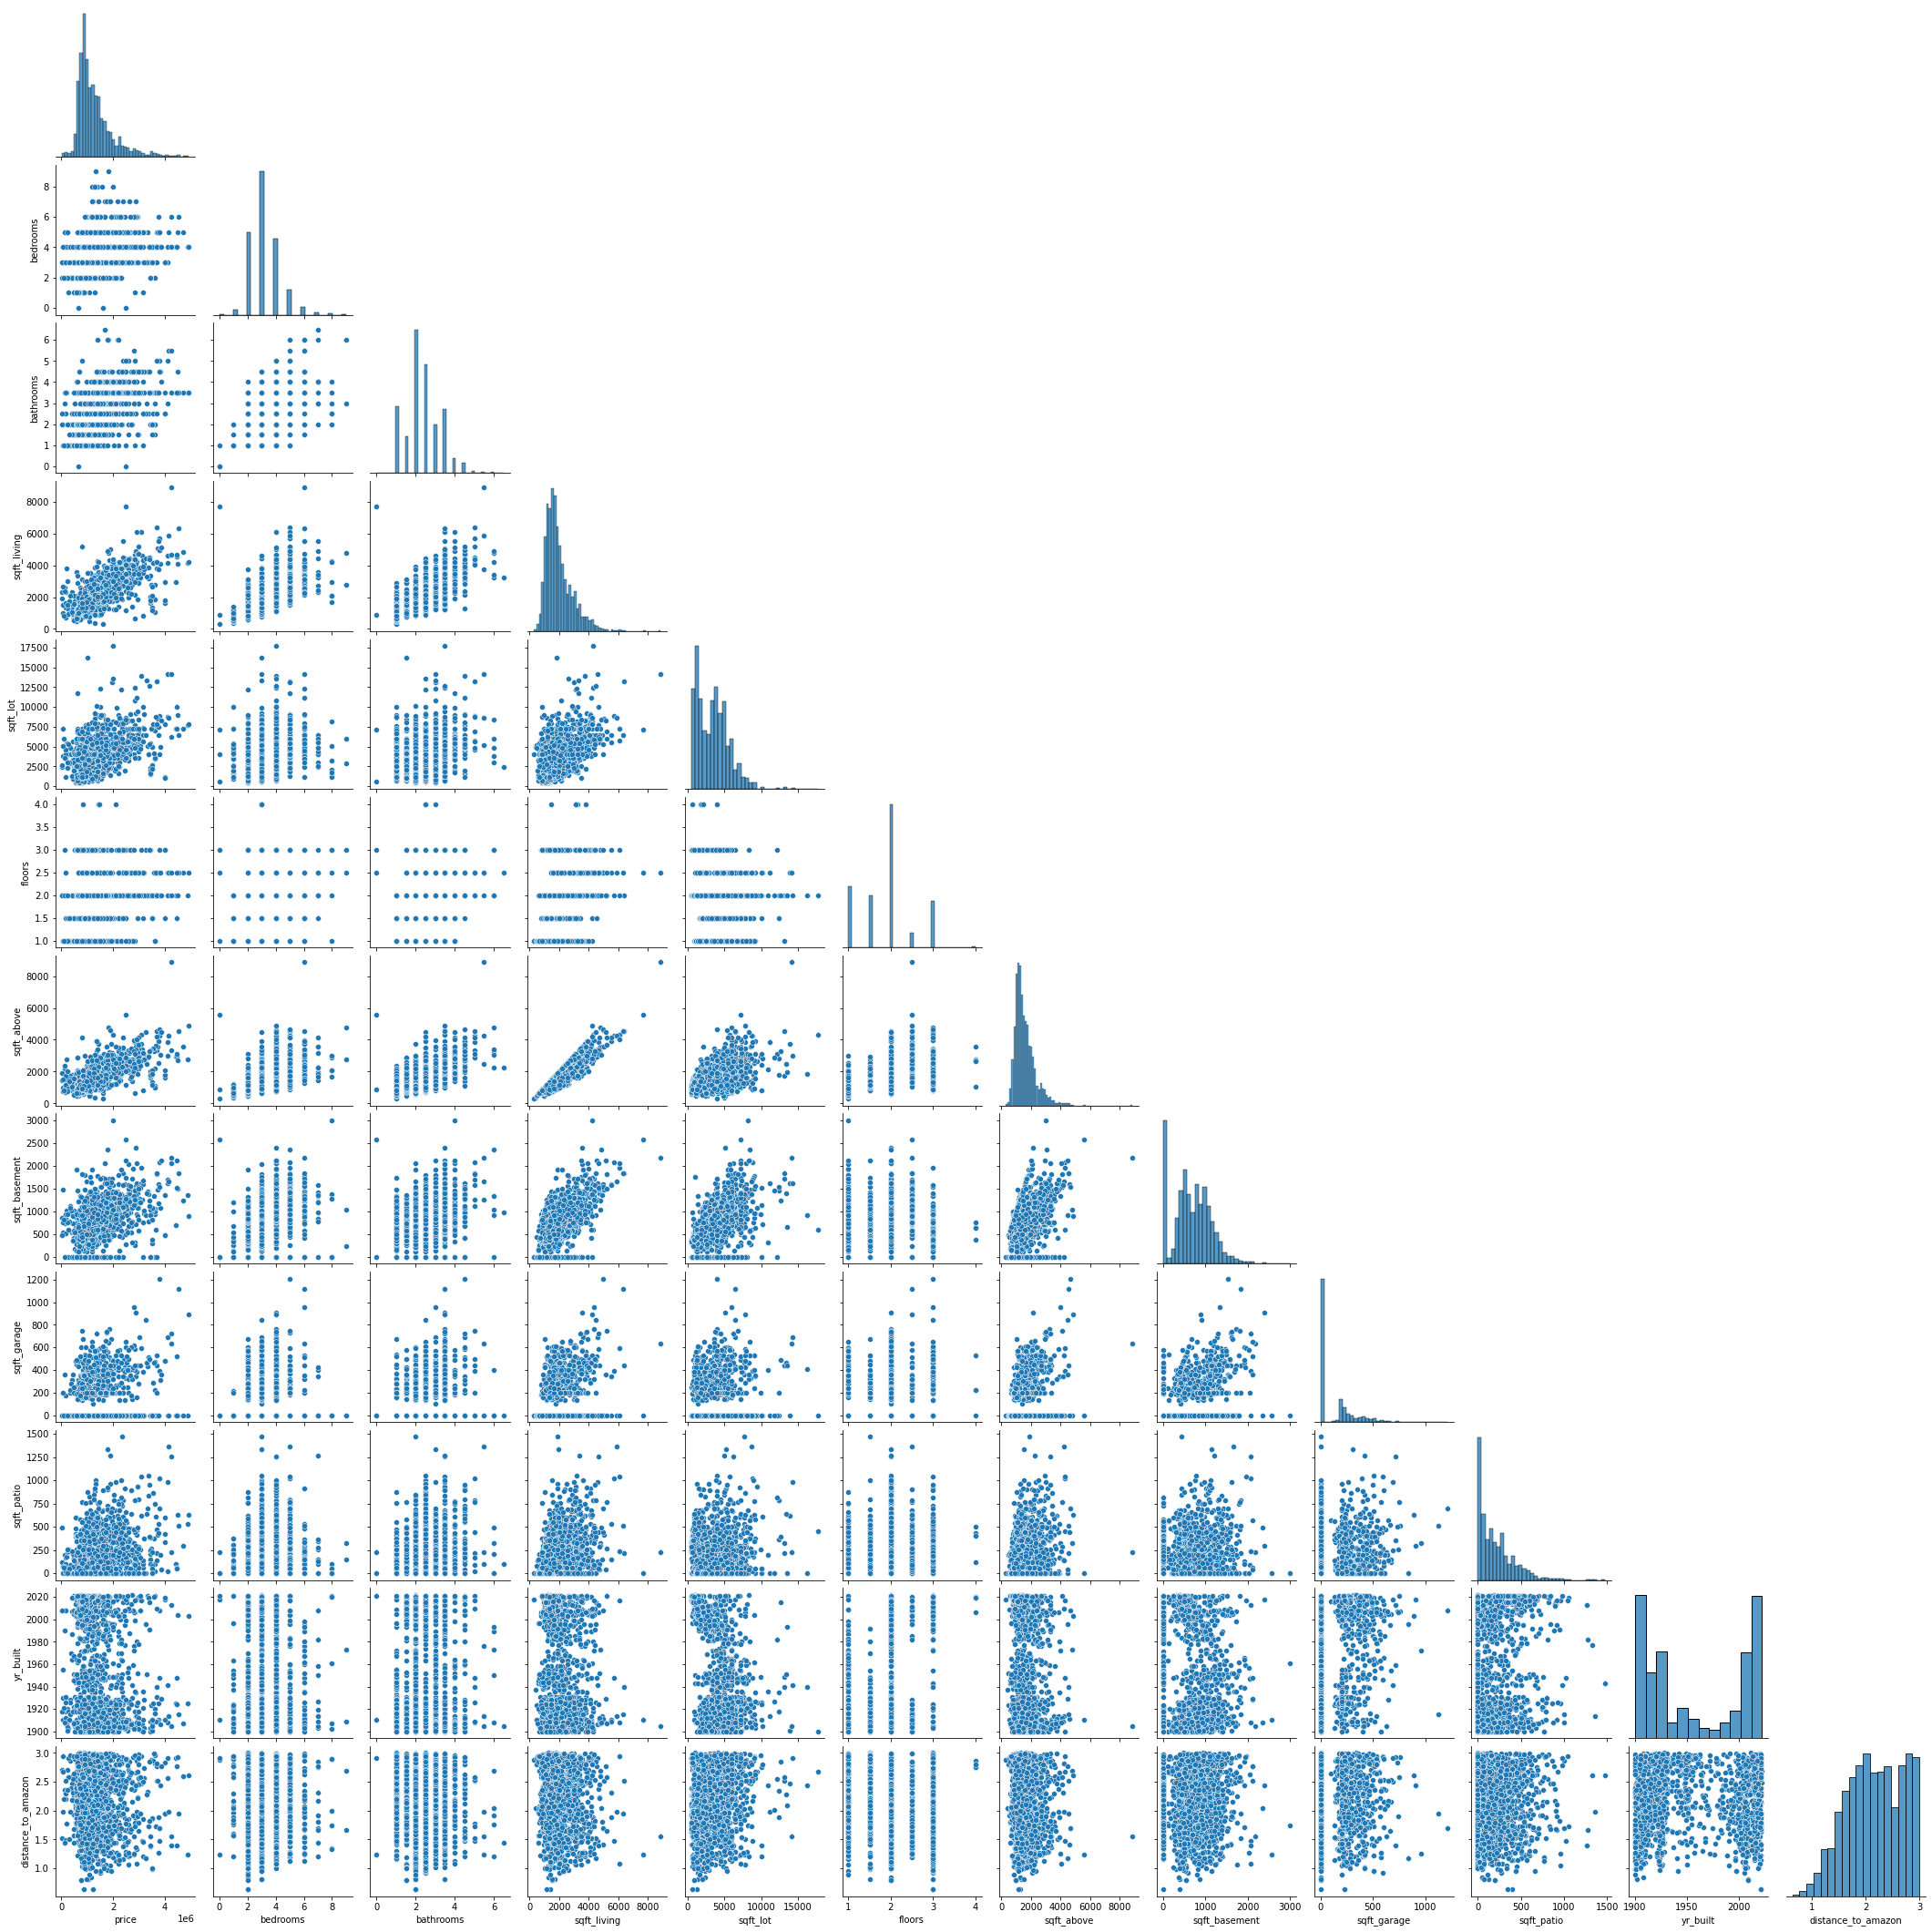

In [18]:
# taking a look at the correlation between prices and dependent variable 
numerical_list = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                  'floors', 'sqft_above', 'sqft_basement', 'sqft_garage', 
                  'sqft_patio', 'yr_built', 'distance_to_amazon']
sns.pairplot(amazon_df[numerical_list], corner = True);

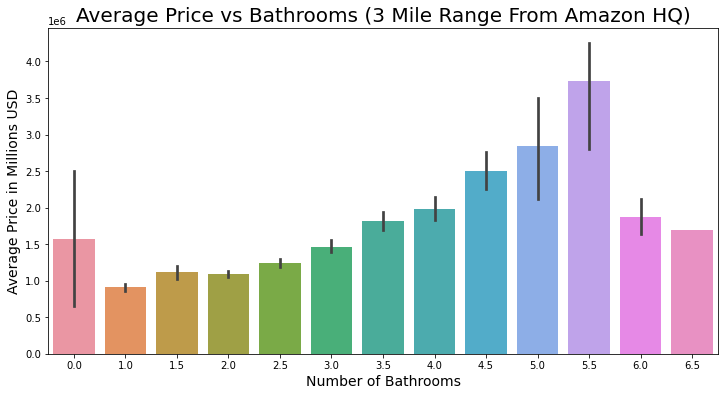

In [19]:
# Plotting the number of bathrooms and their average price
fig, ax = plt.subplots(figsize = (12,6))

x = amazon_df['bathrooms']
y = amazon_df['price']

sns.barplot(x = x, y = y, ax = ax)
ax.set_title('Average Price vs Bathrooms (3 Mile Range From Amazon HQ)', fontsize = 20)
ax.set_ylabel('Average Price in Millions USD', fontsize = 14)
ax.set_xlabel('Number of Bathrooms', fontsize = 14);

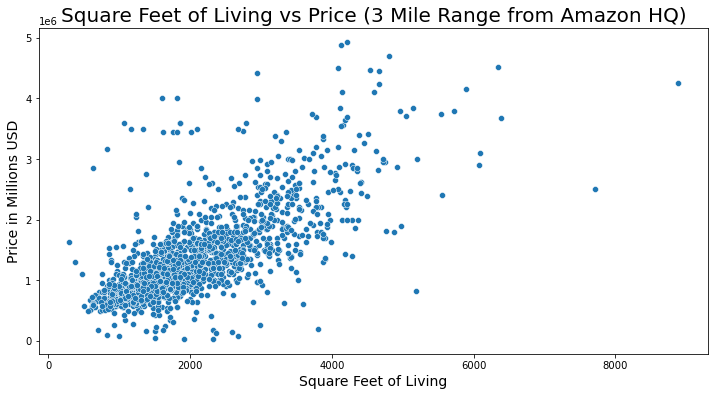

In [20]:
# Plotting the relationship of the sqft of living vs the sale price
fig, ax = plt.subplots(figsize = (12,6))

x = amazon_df['sqft_living']
y = amazon_df['price']
hue = amazon_df['bedrooms']
size = amazon_df['bathrooms']


sns.scatterplot(x = x, y = y, ax=ax)
ax.set_title('Square Feet of Living vs Price (3 Mile Range from Amazon HQ)', fontsize = 20)
ax.set_ylabel('Price in Millions USD', fontsize = 14)
ax.set_xlabel('Square Feet of Living', fontsize = 14);

It appears that **bedrooms, sqft_living, sqft_above** all have strong correlations with **price**

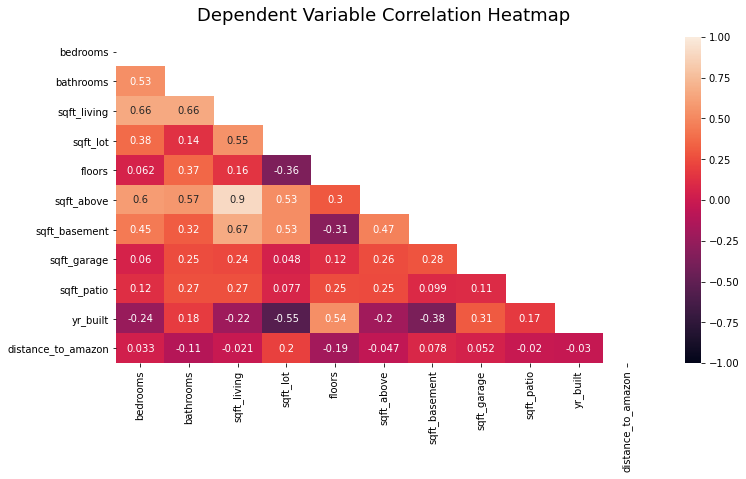

In [21]:
# taking a look at the 
plt.figure(figsize = (12,6))
dependent_var = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                  'floors', 'sqft_above', 'sqft_basement', 'sqft_garage', 
                  'sqft_patio', 'yr_built', 'distance_to_amazon']
mask = np.triu(np.ones_like(abs(amazon_df[dependent_var].corr()), dtype=bool))
heatmap = sns.heatmap(amazon_df[dependent_var].corr(), mask = mask, annot = True, vmax = 1.0 ,vmin =  -1.0)
heatmap.set_title('Dependent Variable Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

SQFT_living and SQFT_above are very correlated need to remove sqft_above from model

## Data Modeling

### Train_Test_Split

In [23]:
# train test split
# Dropping unnecesary columns and very correlated columns
X = amazon_df.drop(columns = ['price', 'date', 'address', 'lat', 'long', 'sqft_above', 'location'])
y = amazon_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 24)

In [28]:
# creating lists for ordinal encoder and nominal pipeline
grade_list = ['2 substandard','3 poor','4 low','5 fair','6 low average', '7 average', '8 good', 
              '9 better', '10 very good', '11 excellent','12 luxury','13 mansion']
cond_list = ['poor', 'fair', 'average', 'good', 'very good']
view_list = ['none', 'fair', 'average', 'good', 'excellent']
nom_list = ['waterfront', 'nuisance', 'greenbelt', 'heat_source', 'sewer_system', 'zip_code']
num_list = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                  'floors', 'sqft_basement', 'sqft_garage', 
                  'sqft_patio', 'yr_built', 'distance_to_amazon']

In [29]:
# creating pipelines for ordinal, nominal and numeric as well as column transformer 
ordinal_pipe = Pipeline([('ord_enc', OrdinalEncoder(categories = [grade_list, cond_list, view_list]))])
nominal_pipe = Pipeline([('one_hot', OneHotEncoder())])
numeric_pipe = Pipeline([('std_scale', StandardScaler())])
preprocessor = ColumnTransformer(transformers = [('ordpipe', ordinal_pipe, ['grade', 'condition', 'view']), 
                                  ('nominalpipe', nominal_pipe, nom_list), 
                                  ('numpipe', numeric_pipe, num_list)])
pipe = Pipeline([('preprocessing', preprocessor), ('model', LinearRegression())])

In [30]:
# creating linear regression model pipeline with preprocessor
pipe = Pipeline([('preprocessing', preprocessor), ('model', LinearRegression())])

In [31]:
# fitting the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ordpipe',
                                                  Pipeline(steps=[('ord_enc',
                                                                   OrdinalEncoder(categories=[['2 '
                                                                                               'substandard',
                                                                                               '3 '
                                                                                               'poor',
                                                                                               '4 '
                                                                                               'low',
                                                                                               '5 '
                                                                                               'fair',
                                                                                               '6 '
                                                                                               'low '
                                                                                               'average',
                                                                                               '7 '
                                                                                               'average',
                                                                                               '8 '
                                                                                               'good',
                                                                                               '9 '
                                                                                               'better',
                                                                                               '10 '
                                                                                               'very '
                                                                                               'good',
                                                                                               '11 '
                                                                                               'excellent',
                                                                                               '12 '
                                                                                               'luxury',
                                                                                               '13 '
                                                                                               'mansion'],
                                                                                              ['poor',
                                                                                               'fair',
                                                                                               'average',
                                                                                               'good',
                                                                                               'very '
                                                                                               'good'],
                                                                                              ['none',
                                                                                               'fair...
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['waterfront', 'nuisance',
                                                   'greenbelt', 'heat_source',
       

In [48]:
ordinal_feature_names = ['grade', 'condition', 'view']

nominal_feature_names = nom_list  

numeric_feature_names = num_list
transformed_feature_names = ordinal_feature_names + nominal_feature_names + numeric_feature_names

linear_regression_model = pipe.named_steps['model']
coefficients = linear_regression_model.coef_

coefficient_pairs = list(zip(coefficients, transformed_feature_names))

sorted_pairs = sorted(coefficient_pairs, key = lambda x: x[0], reverse = True)

for coef, feature_name in sorted_pairs:
    print(f"{feature_name}: {coef}")

sewer_system: 5.42889575375446e+18
bedrooms: 4.904501965780695e+18
zip_code: 4.904501965780466e+18
bathrooms: 4.904501965780452e+18
sqft_lot: 4.904501965780436e+18
sqft_living: 4.904501965779943e+18
yr_built: 1.0018822812997212e+18
sqft_patio: 1.0018822812994662e+18
distance_to_amazon: 1.0018822812994403e+18
sqft_garage: 1.0018822812993622e+18
waterfront: 4.374885996941293e+16
nuisance: 4.37488599691324e+16
grade: 140006.5293844863
view: 47904.94149439675
condition: 43562.45725196709
sqft_basement: -1.869040435807804e+18
floors: -1.8690404358083036e+18
greenbelt: -1.5103403341738766e+19
heat_source: -1.5103403341738805e+19


In [32]:
# making sure that the model is not overfitting on the train set
print(f'R^2 value of train set: {pipe.score(X_train, y_train)}')
print(f'R^2 value of test set: {pipe.score(X_test, y_test)}')

R^2 value of train set: 0.6361499214028349
R^2 value of test set: 0.6024016008805633


In [33]:
# getting the predicted price values from the trained model
y_pred = pipe.predict(X_test)

In [53]:
# calculating mean absolute error and RMSE of the predicted and true prices
Mae = mean_absolute_error(y_test, y_pred)
print('MAE', MAE.round(2))
mse = mean_squared_error(y_test, y_pred)
print('RMSE', np.sqrt(mse.round(2)))

MAE 255106.86
RMSE 415892.18965049105


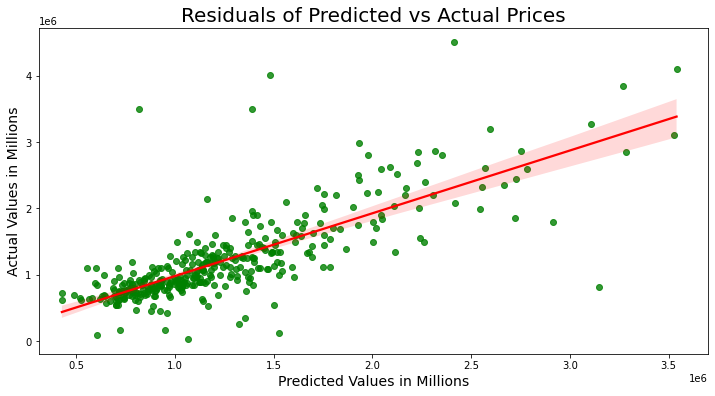

In [36]:
# plotting residual plot
plt.figure(figsize = (12,6))
plt.title('Residuals of Predicted vs Actual Prices', fontsize = 20)
plt.xlabel('Predicted Values in Millions', fontsize = 14)
sns.regplot(x = y_pred, y = y_test, scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.ylabel('Actual Values in Millions', fontsize = 14)
plt.xlim([309000, 3700000]);

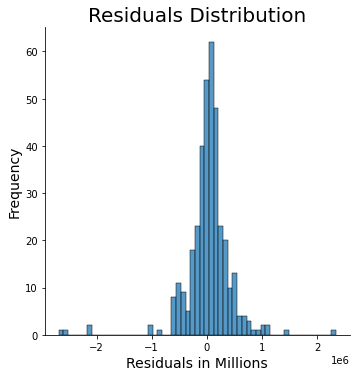

In [37]:
# plotting distribution plot
sns.displot(y_pred - y_test)
plt.title('Residuals Distribution', fontsize = 20)
plt.xlabel('Residuals in Millions', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14);